# Content-Based Collaborative Filtering

## Overview
Content-Based Filtering recommends items similar to those a user has liked, based on item features rather than user behavior. It uses TF-IDF vectorization on product metadata (title, description, features, categories) to compute item-item similarity. If a user rated Item A highly and Item B has similar content, Item B is recommended. This approach handles cold-start items well and provides explainable recommendations.

## Notebook Structure
1. **Setup**: Import libraries, configure paths, detect phase, and set TF-IDF parameters
2. **Core Functions**: Metadata loading with multi-field weighting, TF-IDF vectorization, item-item similarity computation
3. **Recommendation**: Predict scores using weighted average of similar items based on content similarity
4. **Evaluation**: RMSE, accuracy, and ranking metrics (Recall@K, NDCG@K, MAP@K)
5. **Hyperparameter Tuning**: K-neighbor (top-K similar items) optimization with NDCG-primary selection
6. **Pipeline**: Automated training, tuning, and evaluation with visualizations

## Process Flow
**Phase 1 - Training & Tuning:**
- Load 5-core train + metadata → Combine text fields with weights (title 3x, features 2x, description 1x, categories 1x)
- Preprocess text: lowercase, remove special chars, stopwords → TF-IDF vectorization → Compute item-item cosine similarity
- Test K values on validation set → Select best K using NDCG@10 (primary), Recall@10 (tiebreaker)
- Save model with optimal K

**Phase 2 - Final Evaluation:**
- Load tuned model → Evaluate on test set → Generate metrics and visualizations

In [1]:
import os, sys, json, pickle, re, time
import numpy as np, polars as pl
from pathlib import Path
from scipy.sparse import csr_matrix, save_npz, load_npz
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords

try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords', quiet=True)

module_path = os.path.abspath(os.path.join('..', '../utilities'))
sys.path.append(module_path)

from logger import Logger
from configurations import Configurations
from visualization_helpers import visualize_hyperparameter_tuning, visualize_final_results, visualize_val_test_comparison
from evaluation_metrics import compute_rmse_accuracy, recall_at_k, ndcg_at_k, map_at_k

logger = Logger(process_name="content_based", log_file=Configurations.LOG_PATH)

PROCESSED_DIR = Path(Configurations.DATA_PROCESSED_PATH)
RAW_DIR = Path(Configurations.DATA_RAW_PATH)
MODELS_DIR = Path(Configurations.MODELS_PATH)
CATEGORY = Configurations.CATEGORIES

has_tuning = Configurations.has_tuning_results_content(CATEGORY[0])
K_VALUES = Configurations.K_VALUES_CONTENT
EVAL_K_VALUES = [10, 20, 50]
PHASE = 'final' if has_tuning else 'train_tune'

logger.log_info("="*70)
logger.log_info(f"PHASE: {'FINAL EVALUATION' if has_tuning else 'TRAINING + TUNING'} (CONTENT-BASED)")
logger.log_info(f"Categories: {CATEGORY} | Sample: {Configurations.DEV_SAMPLE_SIZE}")
if not has_tuning:
    logger.log_info(f"K values: {K_VALUES}")
logger.log_info(f"Eval K values: {EVAL_K_VALUES}")
logger.log_info("="*70 + "\n")

N_RECS = 10
MAX_USERS = None
MAX_ITEMS = None
TOP_K_SIMILAR = 30
TFIDF_MAX_FEATURES = 5000
TFIDF_MIN_DF = 2
TFIDF_NGRAM_RANGE = (1, 2)

2025-11-03 01:30:08,236 - INFO - ======================================================================
2025-11-03 01:30:08,237 - INFO - PHASE: TRAINING + TUNING (CONTENT-BASED)
2025-11-03 01:30:08,237 - INFO - Categories: ['Electronics', 'Beauty_and_Personal_Care', 'Sports_and_Outdoors'] | Sample: big
2025-11-03 01:30:08,237 - INFO - K values: [10]
2025-11-03 01:30:08,238 - INFO - Eval K values: [10, 20, 50]
2025-11-03 01:30:08,238 - INFO - ======================================================================



In [2]:
def _candidate_files(category: str, split: str = "train"):
    dev_sample = Configurations.DEV_SAMPLE_SIZE
    safe_cat = category.replace('/', '-')
    if dev_sample != 'full':
        for size_name in Configurations.SAMPLE_SIZES.keys():
            if size_name == dev_sample:
                return PROCESSED_DIR / f"{safe_cat}.5core.{split}.{size_name}.parquet"
    return PROCESSED_DIR / f"{safe_cat}.5core.{split}.parquet"

def load_5core_data(category: str, split: str = "train") -> pl.DataFrame:
    p = _candidate_files(category, split)
    df = pl.read_parquet(p, low_memory=False).__copy__()
    logger.log_info(f"[{split.upper()}] shape={df.shape} | users={df['user_id'].n_unique()} | items={df['parent_asin'].n_unique()}")
    return df

def load_metadata(category: str) -> pl.DataFrame:
    stop_words = set(stopwords.words('english'))
    
    def preprocess_text(text: str) -> str:
        if not text or not isinstance(text, str) or not text.strip():
            return ""
        text = re.sub(r'[^a-z0-9\s]', ' ', text.lower())
        text = re.sub(r'\s+', ' ', text)
        words = [w for w in text.split() if w not in stop_words and len(w) > 2]
        return ' '.join(words).strip()
    
    def combine_text_fields(row: dict) -> str:
        title = str(row.get('title', '') or '')
        description = row.get('description', [])
        features = row.get('features', [])
        categories = row.get('categories', [])
        
        desc_text = ' '.join(str(d) for d in description if d) if isinstance(description, list) else str(description or '')
        feat_text = ' '.join(str(f) for f in features if f) if isinstance(features, list) else str(features or '')
        cat_text = ' '.join(str(c) for c in categories if c) if isinstance(categories, list) else str(categories or '')
        
        return f"{title} {title} {title} {feat_text} {feat_text} {desc_text} {cat_text}".strip()
    
    safe_cat = category.replace('/', '-')
    p = PROCESSED_DIR / f"{safe_cat}.meta.parquet"
    
    if not p.exists():
        raise FileNotFoundError(f"Metadata not found: {p}")
    
    df = pl.read_parquet(p, low_memory=False)
    
    for col in ['title', 'description', 'features', 'categories']:
        if col not in df.columns:
            df = df.with_columns(pl.lit([]).alias(col) if col in ['features', 'categories'] else pl.lit("").alias(col))
    
    combined_texts = [combine_text_fields(row) for row in df.iter_rows(named=True)]
    processed_texts = [preprocess_text(text) for text in combined_texts]
    
    df = df.with_columns(pl.Series("description", processed_texts))
    df = df.filter(pl.col('description').str.len_chars() > 0)
    
    logger.log_info(f"[Metadata] {len(df):,} items with valid descriptions")
    return df.select(['parent_asin', 'description'])

In [3]:
def build_content_model(df_train: pl.DataFrame, df_meta: pl.DataFrame, 
                       max_users: int | None = None, max_items: int | None = None,
                       max_features: int = 5000, min_df: int = 2, 
                       ngram_range: tuple = (1, 2)):
    df = df_train.select(['user_id', 'parent_asin', 'rating']).with_columns(pl.col('rating').cast(pl.Float32))
    
    if max_users:
        df = df.filter(pl.col('user_id').is_in(df['user_id'].unique()[:max_users]))
    if max_items:
        df = df.filter(pl.col('parent_asin').is_in(df['parent_asin'].unique()[:max_items]))
    
    item_list = df['parent_asin'].unique().to_list()
    df_meta_filtered = df_meta.filter(pl.col('parent_asin').is_in(item_list))
    
    user_rev = df['user_id'].unique().to_list()
    item_rev = item_list
    user_idx = {u: i for i, u in enumerate(user_rev)}
    item_idx = {a: i for i, a in enumerate(item_rev)}
    
    u = np.array([user_idx[x] for x in df['user_id'].to_list()], dtype=np.int32)
    i = np.array([item_idx[x] for x in df['parent_asin'].to_list()], dtype=np.int32)
    v = np.array(df['rating'].to_list(), dtype=np.float32)
    
    R = csr_matrix((v, (u, i)), shape=(len(user_rev), len(item_rev)), dtype=np.float32)
    
    meta_dict = {row['parent_asin']: row['description'] for row in df_meta_filtered.iter_rows(named=True)}
    descriptions = [meta_dict.get(asin, "") for asin in item_rev]
    missing = sum(1 for d in descriptions if not d or not d.strip())
    
    logger.log_info(f"[Content] {len(descriptions) - missing:,} valid descriptions, {missing:,} missing")
    
    vectorizer = TfidfVectorizer(max_features=max_features, stop_words='english', 
                                 min_df=min_df, ngram_range=ngram_range)
    tfidf_matrix = vectorizer.fit_transform(descriptions)
    item_similarity = cosine_similarity(tfidf_matrix, dense_output=False)
    
    item_similarity.data[item_similarity.data < 0.01] = 0
    item_similarity.eliminate_zeros()
    
    logger.log_info(f"[Model] R{R.shape} | TF-IDF{tfidf_matrix.shape} | Similarity{item_similarity.shape} nnz={item_similarity.nnz:,}")
    
    return R, user_idx, item_idx, np.array(user_rev, dtype=object), np.array(item_rev, dtype=object), item_similarity, vectorizer

In [4]:
def predict_content_based(user_idx_val: int, R: csr_matrix, item_similarity: csr_matrix, 
                         top_k: int = 30) -> np.ndarray:
    user_ratings = R.getrow(user_idx_val).toarray().ravel()
    rated_items = np.nonzero(user_ratings)[0]
    
    if len(rated_items) == 0:
        return np.zeros(R.shape[1], dtype=np.float32)
    
    rated_ratings = user_ratings[rated_items]
    scores = np.zeros(R.shape[1], dtype=np.float32)
    sim_matrix = item_similarity[:, rated_items].toarray()
    
    for i in range(R.shape[1]):
        sims = sim_matrix[i, :]
        positive_mask = sims > 0
        n_positive = positive_mask.sum()
        
        if n_positive == 0:
            continue
        
        sims_positive = sims[positive_mask]
        ratings_positive = rated_ratings[positive_mask]
        k_use = min(top_k, n_positive)
        
        if k_use <= 0:
            continue
        
        if k_use < n_positive:
            top_idx = np.array([np.argmax(sims_positive)]) if k_use == 1 else \
                     np.argpartition(-sims_positive, min(k_use-1, len(sims_positive)-1))[:k_use]
        else:
            top_idx = np.arange(n_positive)
        
        if len(top_idx) == 0:
            continue
        
        final_sims = sims_positive[top_idx]
        final_ratings = ratings_positive[top_idx]
        sim_sum = np.sum(final_sims)
        
        if sim_sum > 1e-8:
            scores[i] = np.dot(final_sims, final_ratings) / sim_sum
    
    return scores

def recommend_content_based(user_id: str, n_recs: int, artifacts: dict) -> pl.DataFrame:
    R, user_idx, item_rev = artifacts['R'], artifacts['user_idx'], artifacts['item_rev']
    item_similarity = artifacts['item_similarity']
    top_k = artifacts.get('top_k_similar', TOP_K_SIMILAR)
    
    if user_id not in user_idx:
        return pl.DataFrame(columns=["parent_asin", "score"])
    
    u = user_idx[user_id]
    scores = predict_content_based(u, R, item_similarity, top_k=top_k)
    rated = set(R.getrow(u).indices.tolist())
    cand_mask = np.ones(R.shape[1], dtype=bool)
    if rated:
        cand_mask[list(rated)] = False
    
    cand_scores = scores[cand_mask]
    if cand_scores.size == 0:
        return pl.DataFrame(columns=["parent_asin", "score"])
    
    n_top = min(n_recs, cand_scores.size)
    cand_indices = np.nonzero(cand_mask)[0]
    top_pos = np.argpartition(-cand_scores, n_top - 1)[:n_top]
    picked = sorted([(int(cand_indices[p]), float(cand_scores[p])) for p in top_pos], key=lambda x: -x[1])
    
    return pl.DataFrame({"parent_asin": [item_rev[i] for i, _ in picked], "score": [s for _, s in picked]})

In [5]:
def save_content_artifacts(out_dir: Path, R, user_rev, item_rev, user_idx, item_idx, item_similarity, vectorizer):
    out_dir.mkdir(parents=True, exist_ok=True)
    save_npz(out_dir / "R.npz", R)
    save_npz(out_dir / "item_similarity.npz", item_similarity)
    with open(out_dir / "user_rev.pkl", "wb") as f: pickle.dump(user_rev, f)
    with open(out_dir / "item_rev.pkl", "wb") as f: pickle.dump(item_rev, f)
    (out_dir / "user_idx.json").write_text(json.dumps({str(k): int(v) for k, v in user_idx.items()}))
    (out_dir / "item_idx.json").write_text(json.dumps({str(k): int(v) for k, v in item_idx.items()}))
    with open(out_dir / "vectorizer.pkl", "wb") as f: pickle.dump(vectorizer, f)

def load_content_artifacts(model_dir: str | Path):
    md = Path(model_dir)
    R = load_npz(md / "R.npz")
    item_similarity = load_npz(md / "item_similarity.npz")
    with open(md / "user_rev.pkl", "rb") as f: user_rev = pickle.load(f)
    with open(md / "item_rev.pkl", "rb") as f: item_rev = pickle.load(f)
    user_idx = {k: int(v) for k, v in json.loads((md / "user_idx.json").read_text()).items()}
    item_idx = {k: int(v) for k, v in json.loads((md / "item_idx.json").read_text()).items()}
    with open(md / "vectorizer.pkl", "rb") as f: vectorizer = pickle.load(f)
    return dict(R=R, item_similarity=item_similarity, user_rev=user_rev, item_rev=item_rev, 
                user_idx=user_idx, item_idx=item_idx, vectorizer=vectorizer)

In [6]:
def evaluate_content_based(category: str, artifacts: dict, k_values: list = None, 
                          split: str = "test", sample_users: int = 3000):
    if k_values is None:
        k_values = [10, 20, 50]
    
    df_eval = load_5core_data(category, split=split)
    train_users = list(artifacts['user_idx'].keys())
    df_eval = df_eval.filter(pl.col('user_id').is_in(train_users))
    
    if len(df_eval) == 0:
        return None
    
    eval_users = df_eval['user_id'].unique().to_list()
    if len(eval_users) > sample_users:
        np.random.seed(42)
        eval_users = np.random.choice(eval_users, sample_users, replace=False).tolist()
    
    metrics_acc = {'rmse': [], 'accuracy': [], **{f'{m}@{k}': [] for m in ['recall', 'ndcg', 'map'] for k in k_values}}
    R, item_idx, item_rev = artifacts['R'], artifacts['item_idx'], artifacts['item_rev']
    item_similarity = artifacts['item_similarity']
    top_k = artifacts.get('top_k_similar', 30)
    
    for user_id in eval_users:
        if user_id not in artifacts['user_idx']:
            continue
        
        u = artifacts['user_idx'][user_id]
        user_eval = df_eval.filter(pl.col('user_id') == user_id)
        actual_items = set(user_eval['parent_asin'].to_list())
        known_items = {item for item in actual_items if item in item_idx}
        
        if not known_items:
            continue
        
        actual_ratings = {row['parent_asin']: row['rating'] for row in user_eval.iter_rows(named=True)}
        scores = predict_content_based(u, R, item_similarity, top_k)
        
        predictions = np.full(R.shape[1], np.nan)
        actuals = np.full(R.shape[1], np.nan)
        for asin in known_items:
            idx = item_idx[asin]
            predictions[idx] = scores[idx]
            actuals[idx] = actual_ratings[asin]
        
        rmse, acc = compute_rmse_accuracy(predictions, actuals)
        if not np.isnan(rmse):
            metrics_acc['rmse'].append(rmse)
            metrics_acc['accuracy'].append(acc)
        
        rated = set(R.getrow(u).indices.tolist())
        cand_mask = np.ones(R.shape[1], dtype=bool)
        if rated:
            cand_mask[list(rated)] = False
        
        cand_scores = scores[cand_mask]
        if cand_scores.size == 0:
            continue
        
        cand_indices = np.nonzero(cand_mask)[0]
        max_k = max(k_values)
        n_top = min(max_k, cand_scores.size)
        top_pos = np.argpartition(-cand_scores, n_top - 1)[:n_top]
        sorted_idx = top_pos[np.argsort(-cand_scores[top_pos])]
        recommended = [item_rev[cand_indices[i]] for i in sorted_idx]
        
        for k in k_values:
            metrics_acc[f'recall@{k}'].append(recall_at_k(recommended, known_items, k))
            metrics_acc[f'ndcg@{k}'].append(ndcg_at_k(recommended, known_items, k))
            metrics_acc[f'map@{k}'].append(map_at_k(recommended, known_items, k))
    
    results = {'category': category, 'split': split, 'n_users': len(eval_users),
               'rmse': np.mean(metrics_acc['rmse']) if metrics_acc['rmse'] else np.nan,
               'accuracy': np.mean(metrics_acc['accuracy']) if metrics_acc['accuracy'] else np.nan}
    
    for k in k_values:
        for metric in ['recall', 'ndcg', 'map']:
            key = f'{metric}@{k}'
            results[key] = np.mean(metrics_acc[key]) if metrics_acc[key] else 0.0
    
    logger.log_info(f"[Eval] RMSE={results['rmse']:.4f}, NDCG@10={results['ndcg@10']:.4f}")
    return results

In [7]:
def select_best_k(df_results: pl.DataFrame):
    ndcg10_col = recall10_col = None
    for col in df_results.columns:
        if col.upper() == 'NDCG@10':
            ndcg10_col = col
        elif col.upper() == 'RECALL@10':
            recall10_col = col
    
    if not ndcg10_col:
        raise ValueError(f"NDCG@10 not found. Columns: {df_results.columns}")
    
    best_k_ndcg = df_results['K'][df_results[ndcg10_col].arg_max()]
    best_ndcg = df_results[ndcg10_col].max()
    threshold = best_ndcg * 0.98
    similar_rows = df_results.filter(pl.col(ndcg10_col) >= threshold)
    
    if len(similar_rows) > 1 and recall10_col:
        best_k = similar_rows['K'][similar_rows[recall10_col].arg_max()]
        logger.log_info(f"Selected K={best_k} (NDCG tiebreak with Recall)")
    else:
        best_k = best_k_ndcg
        logger.log_info(f"Selected K={best_k} (highest NDCG@10)")
    
    return best_k

In [8]:
def _train_single_category(cat, model_dir, K_VALUES, n_eval_tune, eval_k_values):
    if not (model_dir / "R.npz").exists():
        logger.log_info("[Train] Building TF-IDF similarity...")
        df_train = load_5core_data(cat, split="train")
        df_meta = load_metadata(cat)
        R, user_idx, item_idx, user_rev, item_rev, item_similarity, vectorizer = build_content_model(
            df_train, df_meta, max_users=MAX_USERS, max_items=MAX_ITEMS,
            max_features=TFIDF_MAX_FEATURES, min_df=TFIDF_MIN_DF, ngram_range=TFIDF_NGRAM_RANGE
        )
        save_content_artifacts(model_dir, R, user_rev, item_rev, user_idx, item_idx, item_similarity, vectorizer)
    
    if not Configurations.has_tuning_results_content(cat):
        logger.log_info("[Tune] Starting hyperparameter tuning...")
        artifacts = load_content_artifacts(model_dir)
        
        results = []
        for k in K_VALUES:
            eval_artifacts = artifacts.copy()
            eval_artifacts['top_k_similar'] = k
            metrics = evaluate_content_based(cat, eval_artifacts, k_values=eval_k_values, split="valid", sample_users=n_eval_tune)
            
            if metrics:
                result = {'K': k}
                for m in ['ndcg', 'recall', 'map']:
                    for kv in eval_k_values:
                        result[f'{m.upper()}@{kv}'] = metrics[f'{m}@{kv}']
                result['RMSE'] = metrics['rmse']
                result['Accuracy'] = metrics['accuracy']
                results.append(result)
        
        df_results = pl.DataFrame(results)
        df_results.write_csv(MODELS_DIR / 'content' / f'tuning_{cat}.csv')
        best_k = select_best_k(df_results)
        Configurations.save_best_k_content(cat, best_k)
        
        visualize_hyperparameter_tuning(df_results, category=cat, param_col='K',
            param_name='K (Similar Items - Content)', save_dir=MODELS_DIR / 'content', algo_name='Content-Based')
        
        return {'tuned_now': True, 'best_k': best_k}
    
    return {'tuned_now': False, 'best_k': Configurations.load_best_k_content(cat)}

2025-11-03 01:30:08,399 - INFO - PHASE 1: TRAINING + TUNING

2025-11-03 01:30:08,401 - INFO - 
Electronics
2025-11-03 01:30:08,402 - INFO - [Train] Building TF-IDF similarity...
2025-11-03 01:30:08,410 - INFO - [TRAIN] shape=(51914, 4) | users=32556 | items=28
2025-11-03 01:30:54,570 - INFO - [Metadata] 367,049 items with valid descriptions
2025-11-03 01:30:54,727 - INFO - [Content] 28 valid descriptions, 0 missing
2025-11-03 01:30:54,737 - INFO - [Model] R(32556, 28) | TF-IDF(28, 615) | Similarity(28, 28) nnz=710
2025-11-03 01:30:54,783 - INFO - [Tune] Starting hyperparameter tuning...
2025-11-03 01:30:54,799 - INFO - [VALID] shape=(456, 4) | users=456 | items=26
2025-11-03 01:30:55,052 - INFO - [Eval] RMSE=0.8122, NDCG@10=0.1118
2025-11-03 01:30:55,054 - INFO - Selected K=10 (highest NDCG@10)


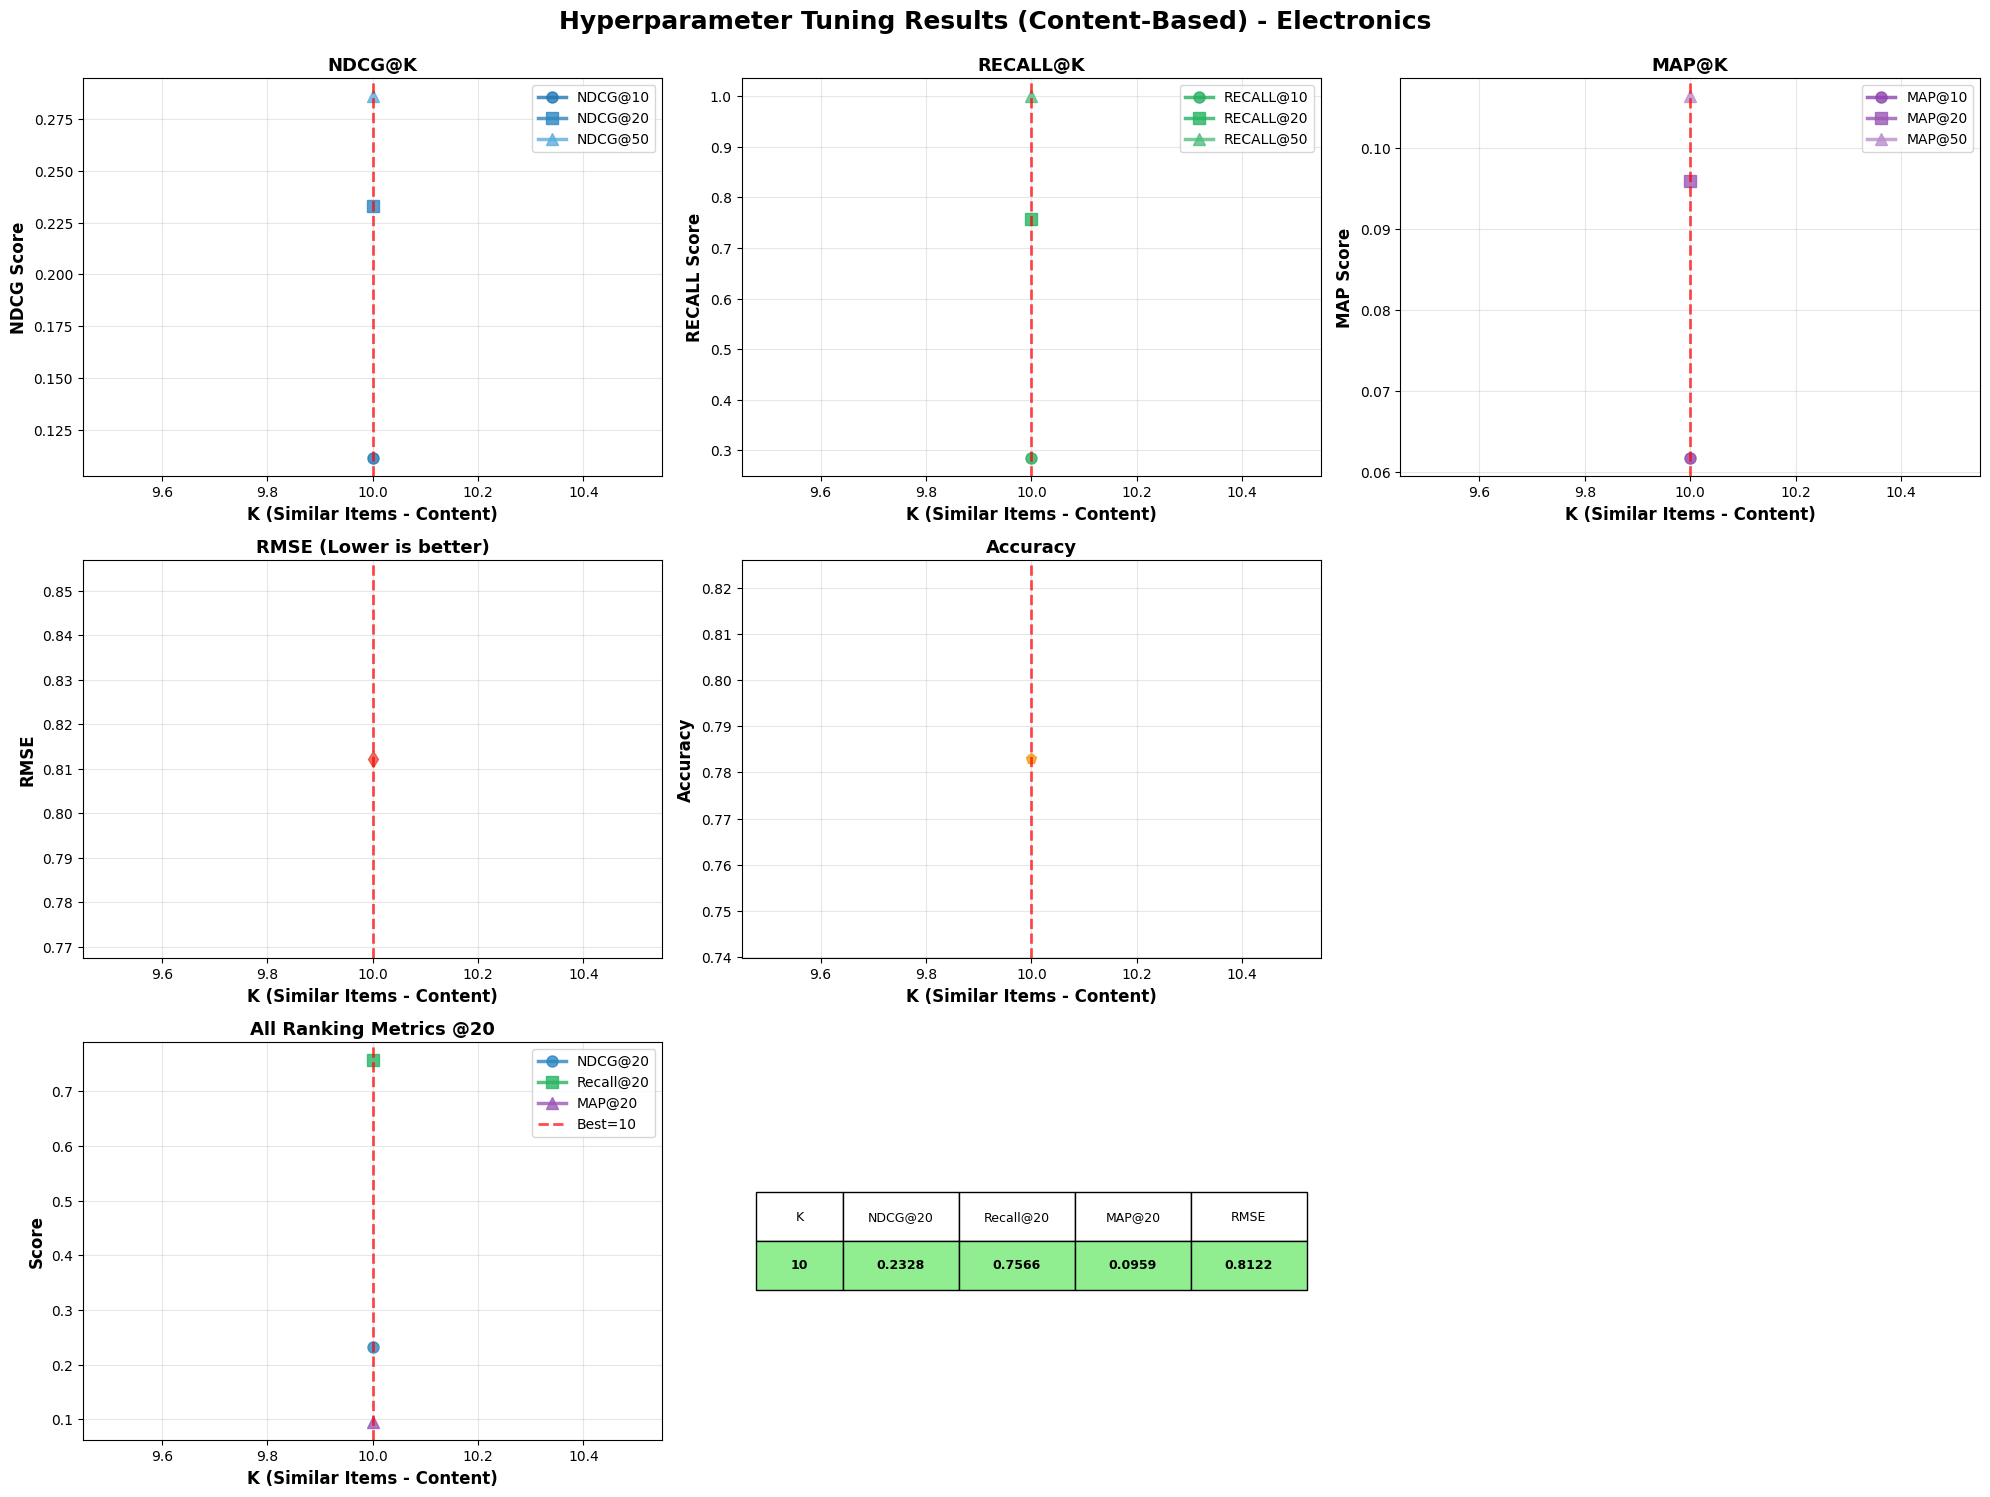

2025-11-03 01:30:55,856 - INFO - 
Beauty_and_Personal_Care
2025-11-03 01:30:55,859 - INFO - [Train] Building TF-IDF similarity...
2025-11-03 01:30:55,863 - INFO - [TRAIN] shape=(22143, 4) | users=16821 | items=23
2025-11-03 01:31:21,821 - INFO - [Metadata] 207,385 items with valid descriptions
2025-11-03 01:31:21,886 - INFO - [Content] 23 valid descriptions, 0 missing
2025-11-03 01:31:21,897 - INFO - [Model] R(16821, 23) | TF-IDF(23, 734) | Similarity(23, 23) nnz=511
2025-11-03 01:31:21,922 - INFO - [Tune] Starting hyperparameter tuning...
2025-11-03 01:31:21,931 - INFO - [VALID] shape=(336, 4) | users=336 | items=23
2025-11-03 01:31:22,109 - INFO - [Eval] RMSE=0.7526, NDCG@10=0.2231
2025-11-03 01:31:22,110 - INFO - Selected K=10 (highest NDCG@10)


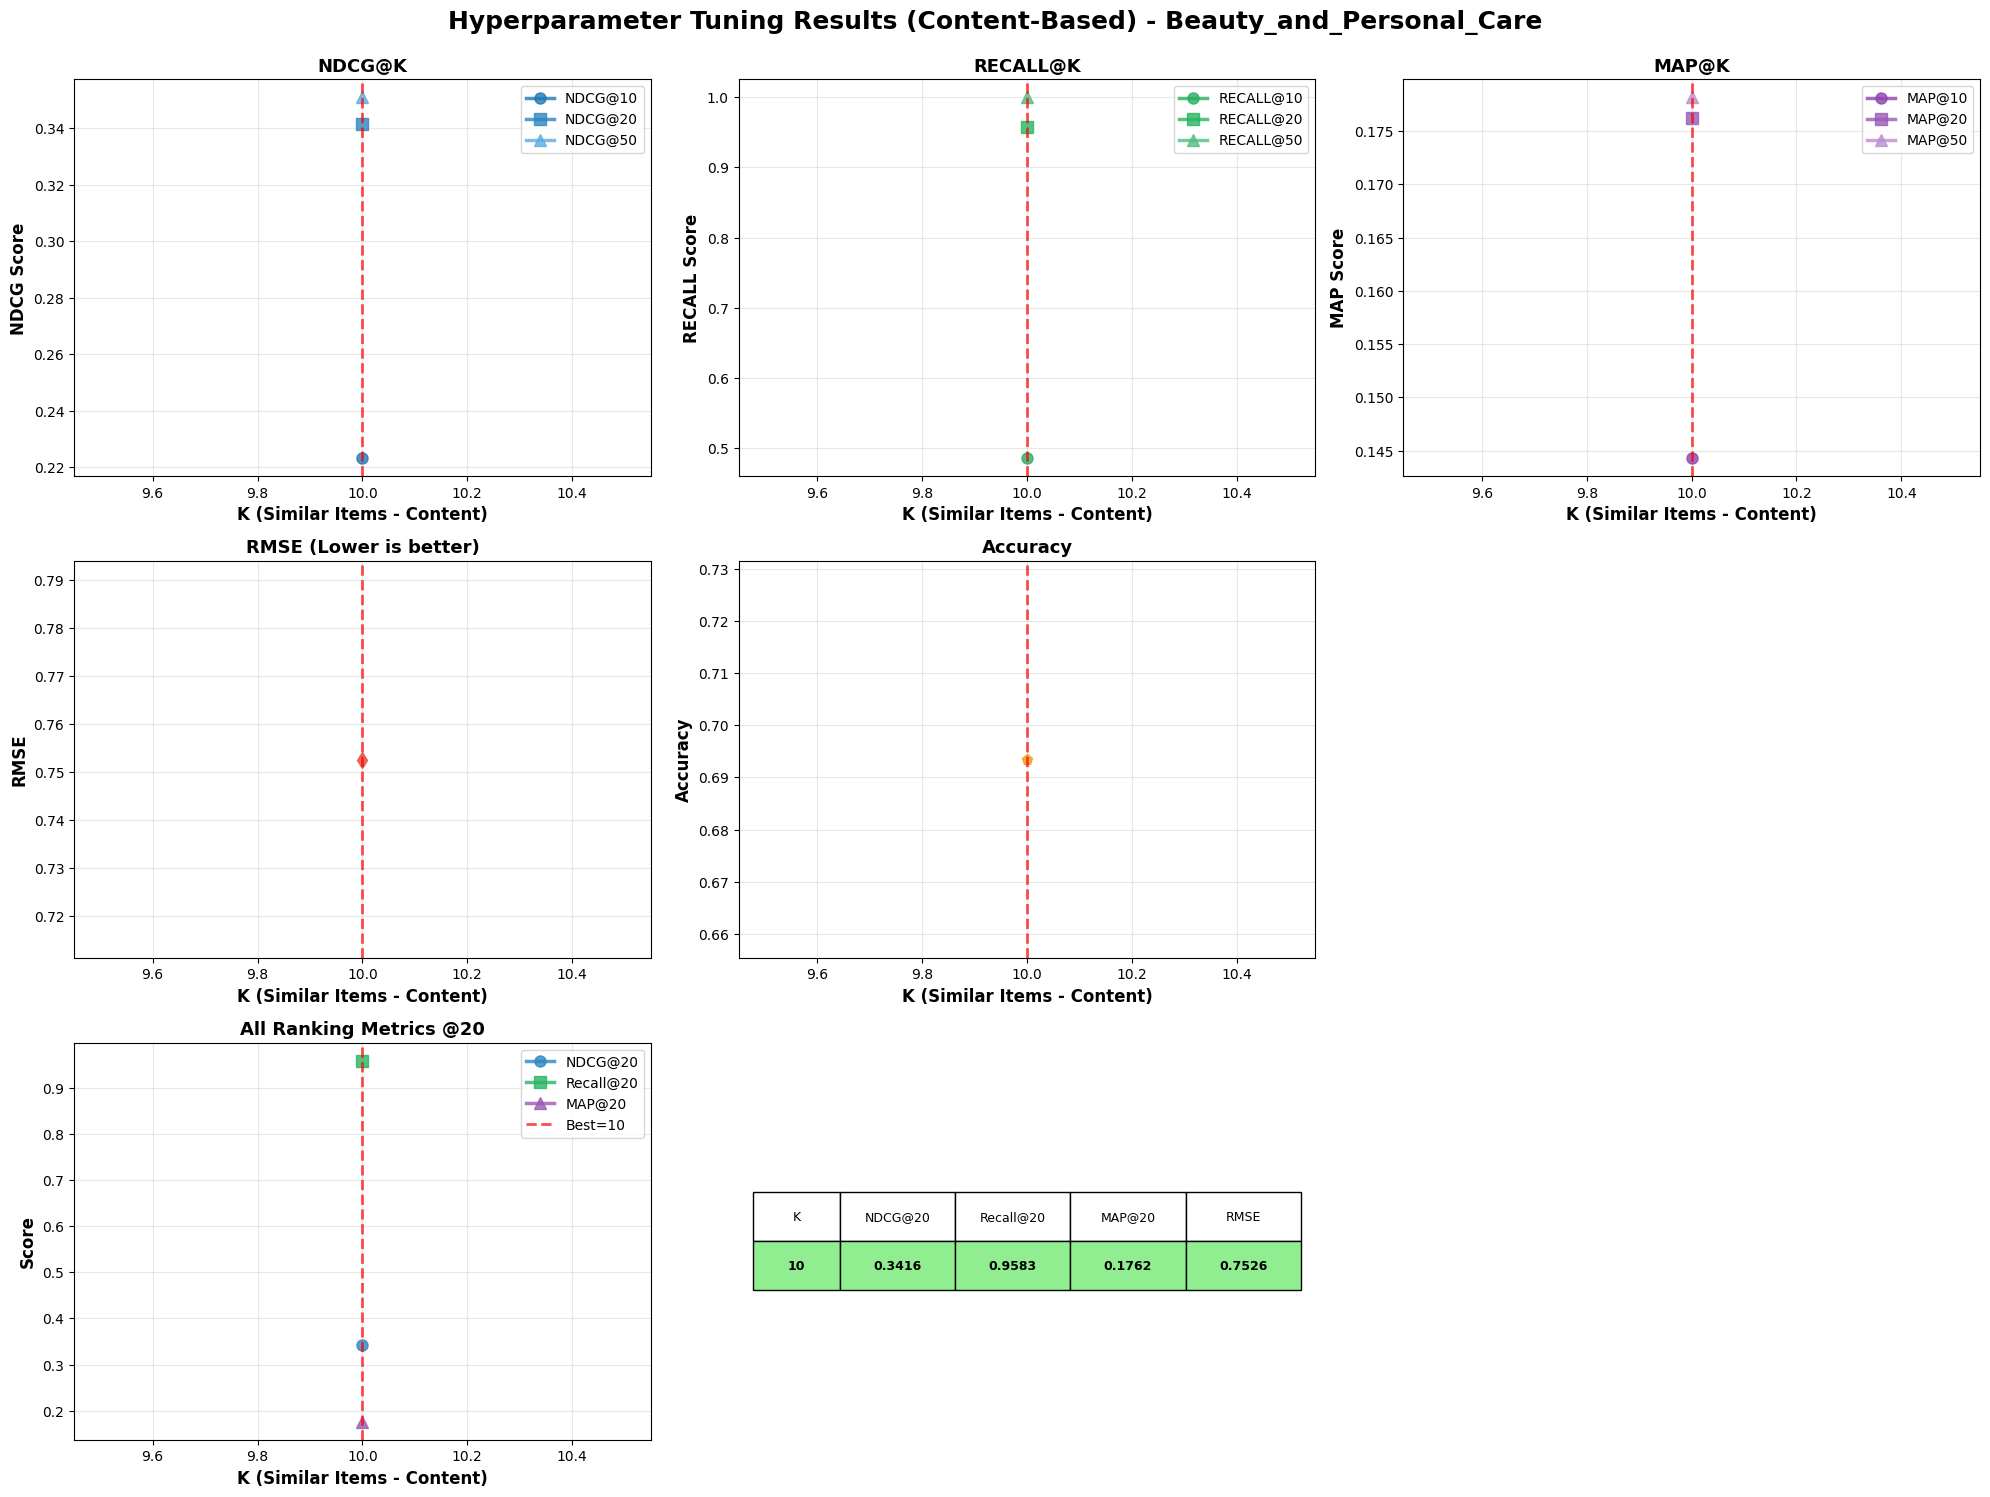

2025-11-03 01:31:22,811 - INFO - 
Sports_and_Outdoors
2025-11-03 01:31:22,812 - INFO - [Train] Building TF-IDF similarity...
2025-11-03 01:31:22,816 - INFO - [TRAIN] shape=(14534, 4) | users=11776 | items=23
2025-11-03 01:33:56,287 - INFO - [Metadata] 1,587,406 items with valid descriptions
2025-11-03 01:33:58,207 - INFO - [Content] 23 valid descriptions, 0 missing
2025-11-03 01:33:58,227 - INFO - [Model] R(11776, 23) | TF-IDF(23, 617) | Similarity(23, 23) nnz=487
2025-11-03 01:33:58,256 - INFO - [Tune] Starting hyperparameter tuning...
2025-11-03 01:33:58,272 - INFO - [VALID] shape=(157, 4) | users=157 | items=23
2025-11-03 01:33:58,396 - INFO - [Eval] RMSE=0.8582, NDCG@10=0.2172
2025-11-03 01:33:58,400 - INFO - Selected K=10 (highest NDCG@10)


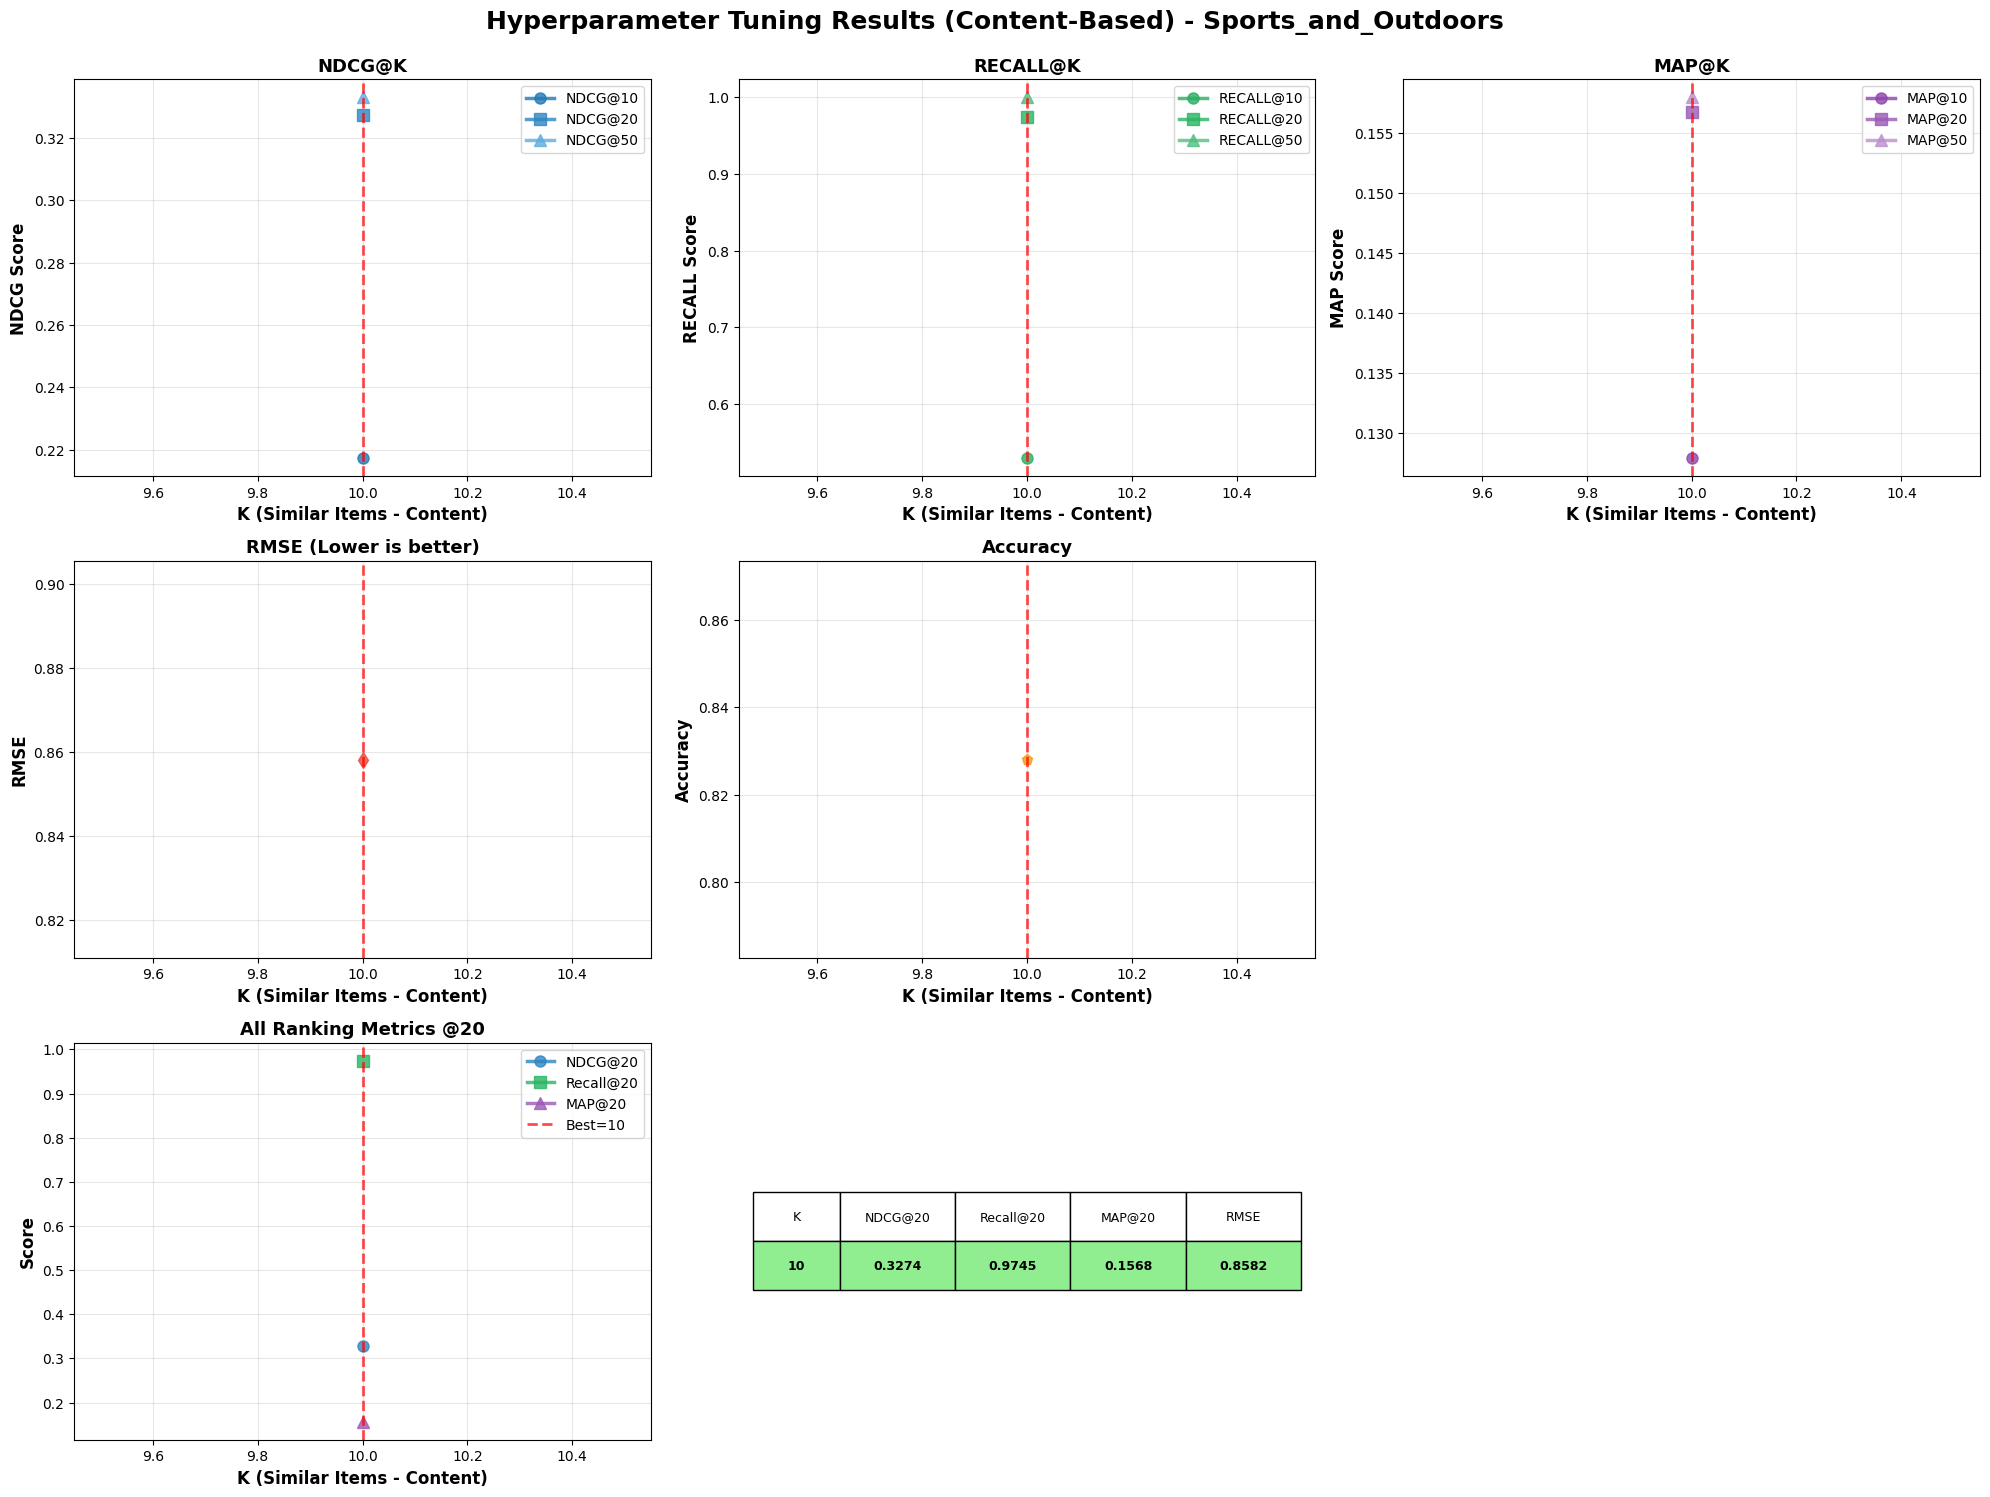

2025-11-03 01:33:59,215 - INFO - 
PHASE 1 COMPLETE
2025-11-03 01:33:59,219 - INFO -   Electronics: K=10 (tuned)
2025-11-03 01:33:59,219 - INFO -   Beauty_and_Personal_Care: K=10 (tuned)
2025-11-03 01:33:59,219 - INFO -   Sports_and_Outdoors: K=10 (tuned)


In [9]:
logger.log_info("PHASE 1: TRAINING + TUNING\n")
workflow_results = {}

for cat in CATEGORY:
    logger.log_info(f"\n{'='*70}\n{cat}\n{'='*70}")
    model_dir = MODELS_DIR / "content" / cat
    workflow_results[cat] = _train_single_category(cat, model_dir, K_VALUES, 
                                                   Configurations.get_eval_samples_tuning(), EVAL_K_VALUES)

logger.log_info("\nPHASE 1 COMPLETE")
for cat in CATEGORY:
    status = 'tuned' if workflow_results[cat]['tuned_now'] else 'cached'
    logger.log_info(f"  {cat}: K={workflow_results[cat]['best_k']} ({status})")

2025-11-03 01:33:59,232 - INFO - 
PHASE 2: FINAL EVALUATION

2025-11-03 01:33:59,233 - INFO - 
Electronics (K=10)
2025-11-03 01:33:59,261 - INFO - [TEST] shape=(349, 4) | users=349 | items=27
2025-11-03 01:33:59,575 - INFO - [Eval] RMSE=0.8195, NDCG@10=0.1180
2025-11-03 01:33:59,576 - INFO - 
Beauty_and_Personal_Care (K=10)
2025-11-03 01:33:59,590 - INFO - [TEST] shape=(304, 4) | users=304 | items=23
2025-11-03 01:33:59,744 - INFO - [Eval] RMSE=0.7681, NDCG@10=0.2306
2025-11-03 01:33:59,745 - INFO - 
Sports_and_Outdoors (K=10)
2025-11-03 01:33:59,757 - INFO - [TEST] shape=(147, 4) | users=147 | items=22
2025-11-03 01:33:59,833 - INFO - [Eval] RMSE=0.8376, NDCG@10=0.2404


category,split,n_users,rmse,accuracy,recall@10,ndcg@10,map@10,recall@20,ndcg@20,map@20,recall@50,ndcg@50,map@50
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""Electronics""","""test""",349,0.81949,0.790831,0.283668,0.11802,0.07092,0.799427,0.250299,0.108258,1.0,0.293658,0.116737
"""Beauty_and_Personal_Care""","""test""",304,0.768113,0.720395,0.486842,0.230572,0.154313,0.953947,0.348606,0.186677,1.0,0.358891,0.188842
"""Sports_and_Outdoors""","""test""",147,0.837605,0.809524,0.55102,0.240367,0.15163,0.972789,0.345612,0.179822,1.0,0.351692,0.181104


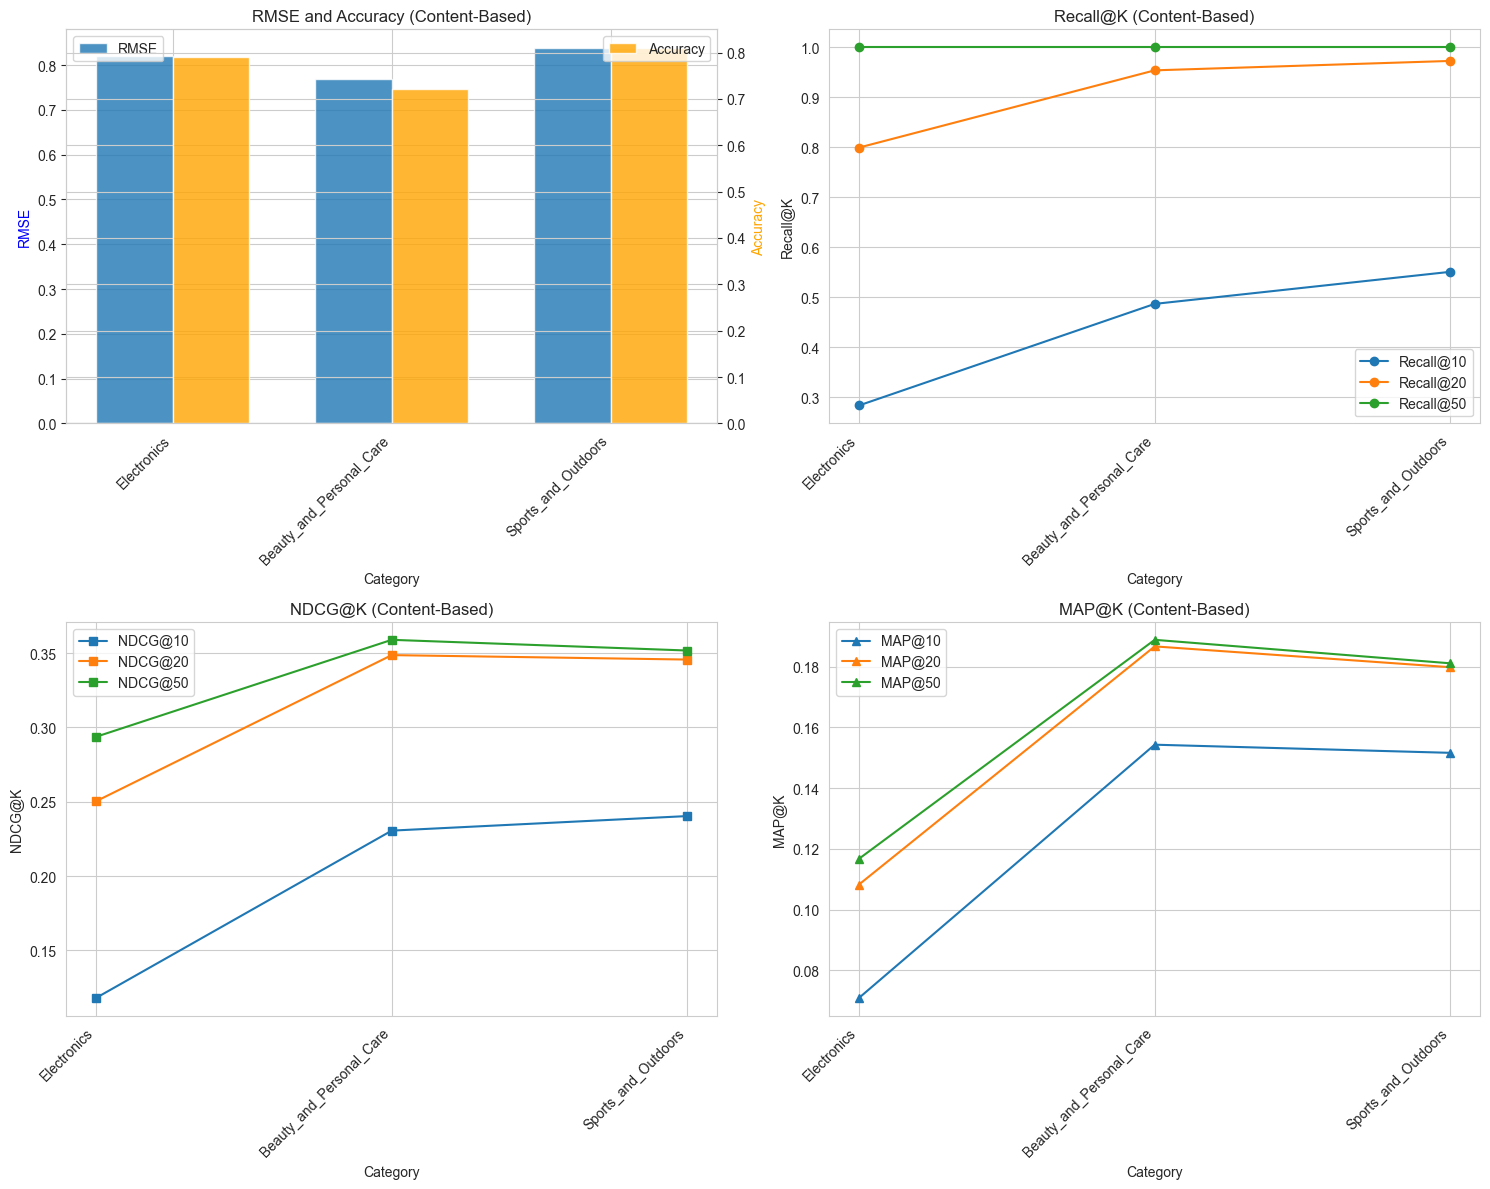

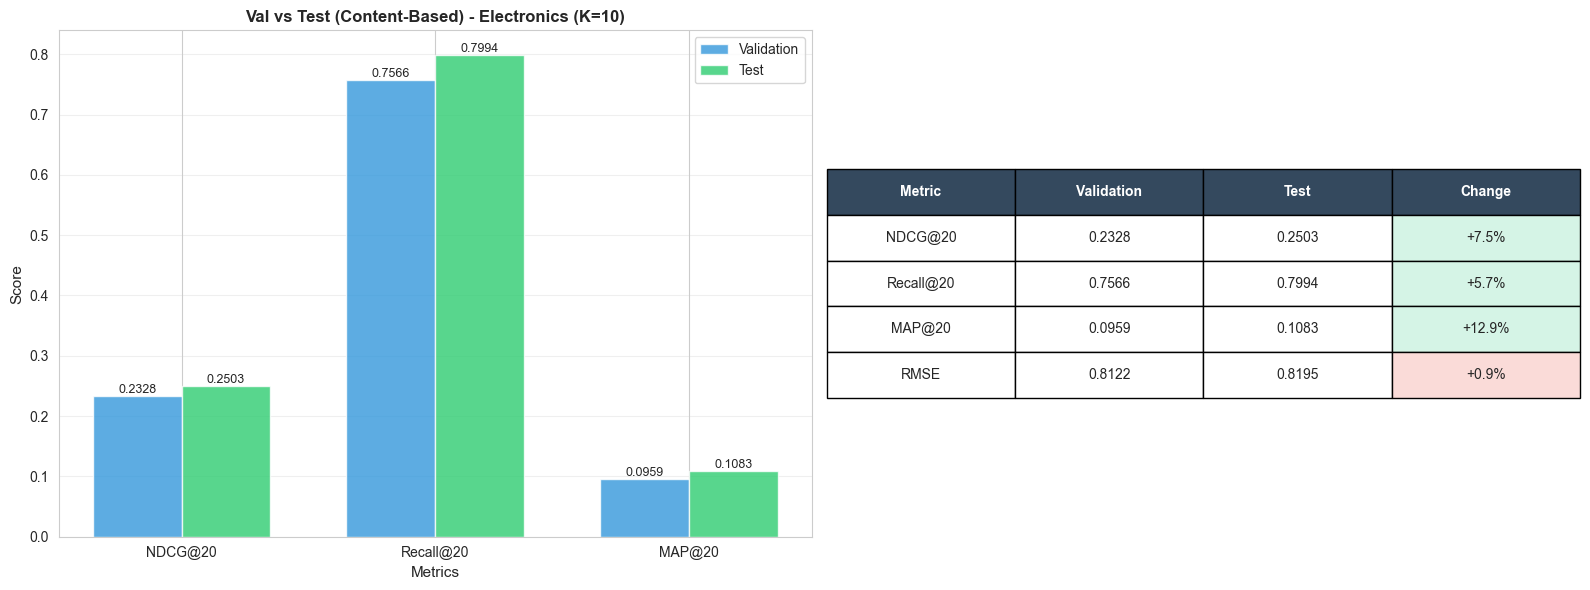

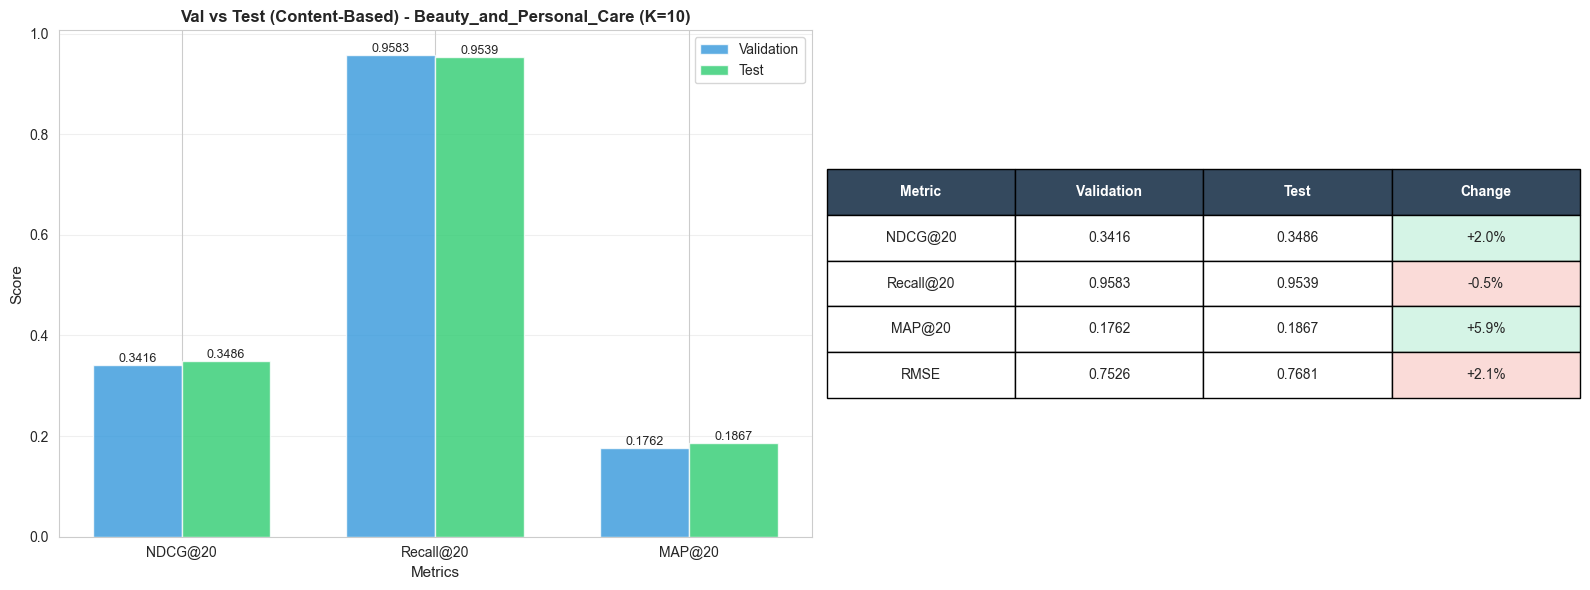

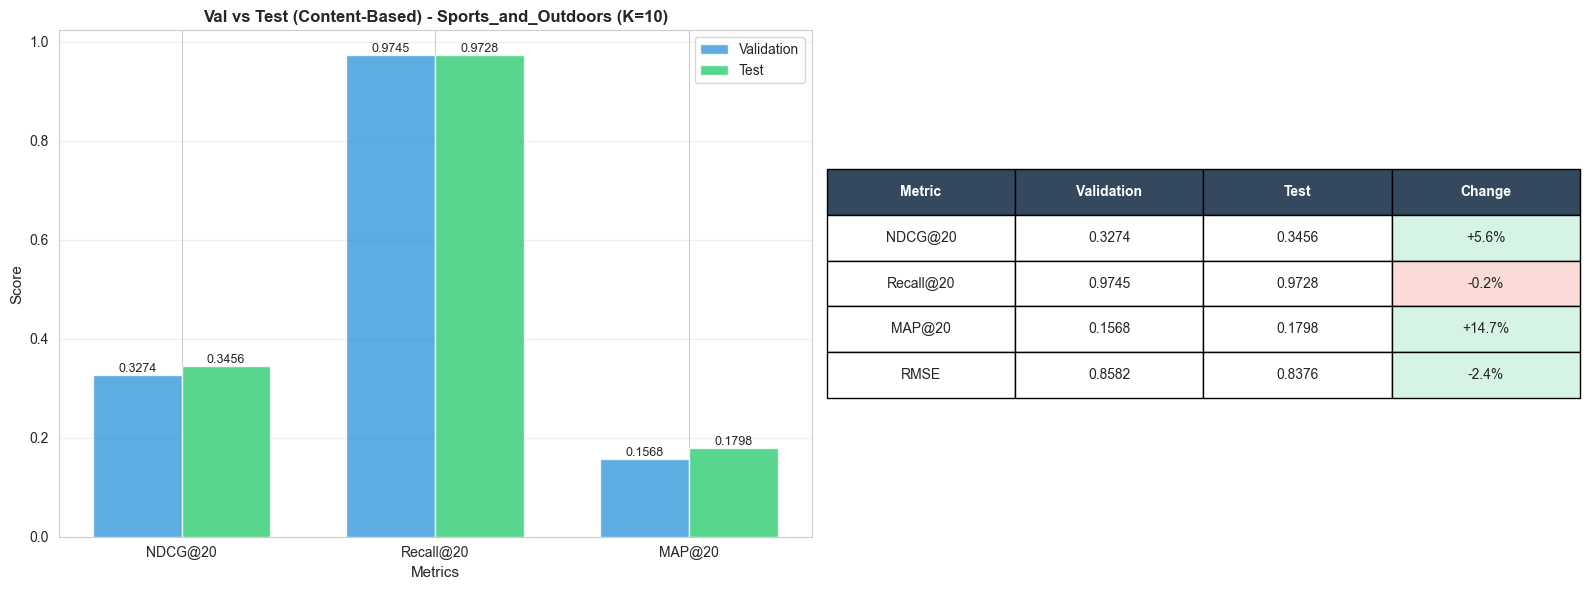

2025-11-03 01:34:01,204 - INFO - 
COMPLETE


In [10]:
logger.log_info("\nPHASE 2: FINAL EVALUATION\n")

if 'workflow_results' not in locals():
    workflow_results = {cat: {'best_k': Configurations.load_best_k_content(cat)} for cat in CATEGORY}

n_eval_final = Configurations.get_eval_samples_final()

for cat in CATEGORY:
    logger.log_info(f"\n{cat} (K={workflow_results[cat]['best_k']})")
    final_artifacts = load_content_artifacts(MODELS_DIR / "content" / cat)
    final_artifacts['top_k_similar'] = workflow_results[cat]['best_k']
    results = evaluate_content_based(cat, final_artifacts, k_values=EVAL_K_VALUES, split="test", sample_users=n_eval_final)
    
    if results:
        workflow_results[cat]['test_results'] = results

test_results = [workflow_results[cat]['test_results'] for cat in CATEGORY if 'test_results' in workflow_results[cat]]
if test_results:
    df_final = pl.DataFrame(test_results)
    display(df_final)
    df_final.write_csv(MODELS_DIR / 'content' / 'final_test_results.csv')
    visualize_final_results(test_results, save_dir=MODELS_DIR / 'content', 
                           algo_name='Content-Based', k_values=EVAL_K_VALUES)

for cat in CATEGORY:
    tuning_csv = MODELS_DIR / 'content' / f'tuning_{cat}.csv'
    if tuning_csv.exists() and 'test_results' in workflow_results[cat]:
        df_tuning = pl.read_csv(tuning_csv)
        best_k = workflow_results[cat]['best_k']
        
        k_values = df_tuning['K'].to_list()
        if best_k not in k_values:
            logger.log_warning(f"best_k={best_k} not in tuning K values {k_values} for {cat}")
            ndcg10_col = next((col for col in df_tuning.columns if col.upper() == 'NDCG@10'), None)
            if ndcg10_col:
                best_k = df_tuning['K'][df_tuning[ndcg10_col].arg_max()]
                logger.log_info(f"Re-selected best_k={best_k} from tuning results")
            else:
                continue
        
        tuning_row = df_tuning.filter(pl.col('K') == best_k).row(0, named=True)
        final_row = df_final.filter(pl.col('category') == cat).row(0, named=True)
        visualize_val_test_comparison(cat=cat, param_val=best_k, tuning_row=tuning_row,
            final_row=final_row, save_dir=MODELS_DIR / 'content', param_name='K', algo_name='Content-Based')

logger.log_info("\nCOMPLETE")

In [11]:
def recommend_content_ui(user_id: str, n_recs: int = 5, models_dir: str | Path | None = None, category: str | None = None):
    cat = category or CATEGORY[0]
    model_dir = Path(models_dir) if models_dir else (MODELS_DIR / "content" / cat)
    artifacts = load_content_artifacts(model_dir)
    artifacts['top_k_similar'] = Configurations.load_best_k_content(cat)
    return recommend_content_based(user_id, n_recs, artifacts)

def test_all_categories():
    for cat in CATEGORY:
        try:
            model_dir = MODELS_DIR / "content" / cat
            if not model_dir.exists():
                continue
            artifacts = load_content_artifacts(model_dir)
            user_rev = artifacts['user_rev']
            if len(user_rev) > 0:
                recs = recommend_content_ui(user_rev[0], n_recs=N_RECS, category=cat)
                display(recs)
        except Exception as e:
            logger.log_exception(f"{cat}: {e}")

In [12]:
test_all_categories()

parent_asin,score
str,f64
"""B09Z3BM734""",4.0
"""B00FB50S0Q""",4.0
"""B07GZFM1ZM""",4.0
"""B07H65KP63""",4.0
"""B08KG14KCT""",4.0
"""B07454F4JH""",4.0
"""B00JO6RO8C""",4.0
"""B00PFQPX5Q""",4.0
"""B075X8471B""",4.0


parent_asin,score
str,f64
"""B0B6QVGZ4X""",4.0
"""B09KM16YYV""",4.0
"""B0C47F7BPT""",4.0
"""B09GN3GC8G""",4.0
"""B01LSUQSB0""",4.0
"""B0CBNPG2FS""",4.0
"""B0BVGHXZJ1""",4.0
"""B00HFG0FAM""",4.0
"""B0BP5GSPLL""",4.0


parent_asin,score
str,f64
"""B07CRN593Y""",5.0
"""B07VN9M9VW""",5.0
"""B0BHX74B31""",5.0
"""B0C8BS352W""",5.0
"""B00C6OUDX2""",5.0
"""B0BWFK1MKG""",5.0
"""B0C4MNRN7R""",5.0
"""B00D3WV3VC""",5.0
"""B0BX4ZDSTQ""",5.0
